<a href="https://colab.research.google.com/github/Koruvika/CV-Project/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ý tưởng
    - Thay gram matrix bằng một pp khác
    - Thử thay style image bằng một ảnh thường
    - Token Mixer

# Các bước thực hiện
- Load 2 ảnh content_image và style_image, tạo ảnh generated_image(bằng tf.Variable)
- Load vgg19 làm feature extractor cho mô hình
- Mô hình chạy như sau:
    - Định nghĩa 3 hàm loss
    - Tính trước vector representation của content_image và style_image và 2 vector này là không đổi suốt training
    - Thứ duy nhất thay đổi trong training là generated_image 

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import PIL.Image
import IPython.display as display
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load 2 ảnh content & style, tạo ảnh generated

In [ ]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [ ]:
content_image = load_image('/content/drive/MyDrive/StyleTransfer/dog.jpg')
style_image = load_image('/content/drive/MyDrive/StyleTransfer/style1.jpg')

In [ ]:
content_image

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909076, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956, 0.40153953, 

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

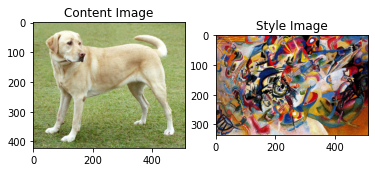

In [ ]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Fast Style Transfer using TF-Hub

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
stylized_image = tensor_to_image(stylized_image)

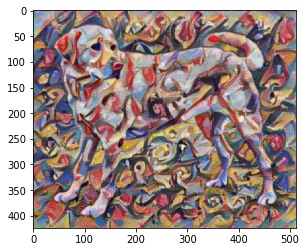

In [ ]:
imshow(stylized_image)

# Load Vgg19

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 9s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317124),
 ('golden_retriever', 0.236653),
 ('kuvasz', 0.036357526),
 ('Chesapeake_Bay_retriever', 0.024182705),
 ('Greater_Swiss_Mountain_dog', 0.018646037)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Build model

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()   

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.887
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.14
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179485



# Calculate Style

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return (result/num_locations)

In [ ]:
class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expect float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }
        return {
            'content' : content_dict,
            'style' : style_dict
        }

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228444
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.473
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320505.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.39
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8772
    mean:  13.764149


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

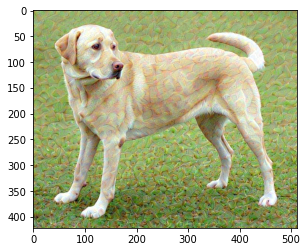

In [ ]:
train_step(image)
train_step(image)
train_step(image)
imshow(tensor_to_image(image))

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

array([[[169, 132,  83],
        [132,  61,  47],
        [ 56, 123,  66],
        ...,
        [ 43,  45,   1],
        [ 82,  29,  24],
        [ 49,  23,  10]],

       [[167, 138, 101],
        [142, 109,  68],
        [ 92, 120,  59],
        ...,
        [ 54,  96,  22],
        [115,  57,  68],
        [ 70,  28,  17]],

       [[176, 160, 173],
        [131,  67,  77],
        [109, 112,  91],
        ...,
        [ 28,  77,  58],
        [ 92,  44,  34],
        [ 98,  97,  36]],

       ...,

       [[254, 198, 137],
        [254, 183, 143],
        [159,  99,  86],
        ...,
        [118,  71, 144],
        [144, 113, 127],
        [115, 116, 163]],

       [[255, 255, 152],
        [229, 249,  88],
        [ 21,   0,   0],
        ...,
        [127, 142, 147],
        [ 84,  91,  81],
        [161, 128, 115]],

       [[146, 155,   0],
        [100,  49,   0],
        [ 35,   0,   0],
        ...,
        [123, 220, 152],
        [ 97,  99,  88],
        [141, 131, 143]]

Train step: 1000
Total time: 270.2


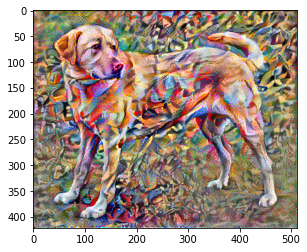

In [ ]:
imshow(tensor_to_image(image))

# Total variation

In [ ]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

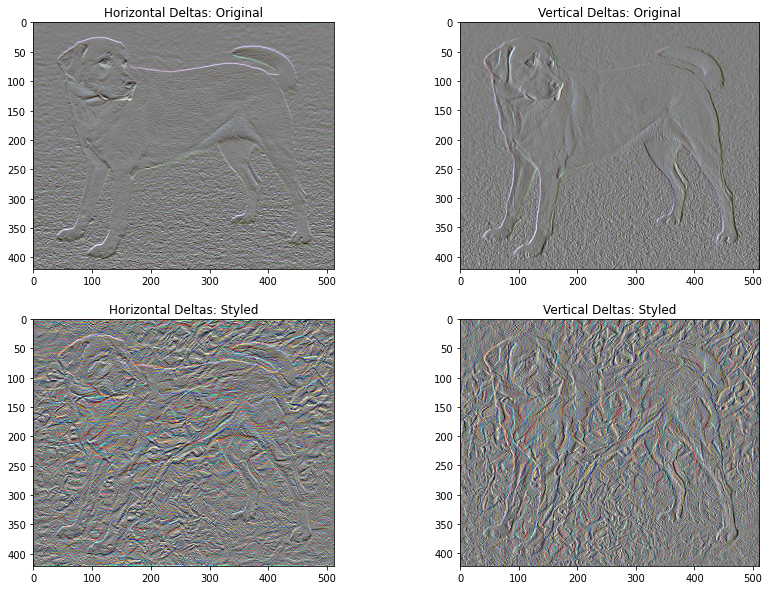

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

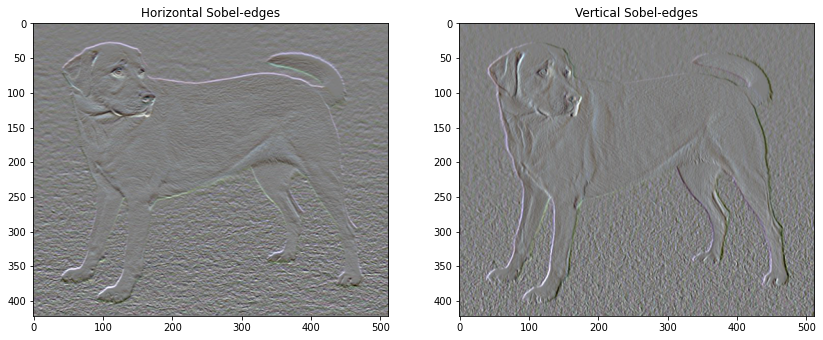

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

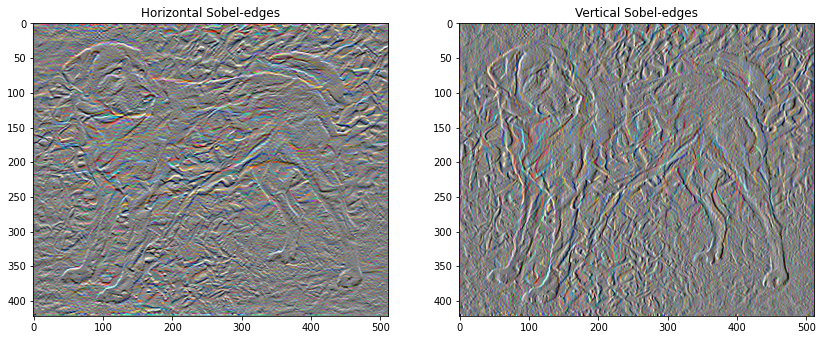

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image = image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

Train step: 1000
Total time: 271.4


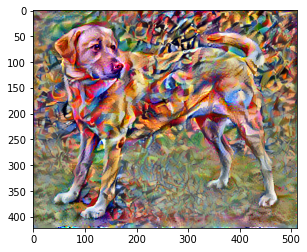

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display_png(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

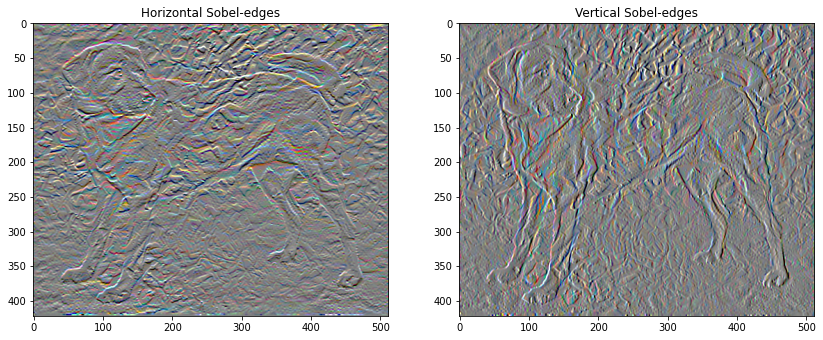

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

# Final Model

- Given style image path & content image path
- Return styled image

In [ ]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

content_image = load_image('/content/drive/MyDrive/StyleTransfer/dog.jpg')
style_image = load_image('/content/drive/MyDrive/StyleTransfer/style1.jpg')

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return (result/num_locations)

class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expect float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }
        return {
            'content' : content_dict,
            'style' : style_dict
        }


extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

total_variation_weight=30
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image = image.assign(clip_0_1(image))

import time
start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display_png(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Train step: 100
Total time: 32.6


# Variation of model

## Variation 1: Combination of some style images

In [ ]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

content_image = load_image('/content/drive/MyDrive/StyleTransfer/dog.jpg')
style_image = load_image('/content/drive/MyDrive/StyleTransfer/style1.jpg')
style_image2 = load_image('/content/drive/MyDrive/StyleTransfer/style2.jpg')

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor
    
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return (result/num_locations)

class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expect float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }
        return {
            'content' : content_dict,
            'style' : style_dict
        }


extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
style_targets2 = extractor(style_image2)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers
    
    style_loss2 = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets2[name])**2) for name in style_outputs.keys()
    ])
    style_loss2 *= style_weight / num_style_layers    

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss + style_loss2
    return loss

total_variation_weight=30
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image = image.assign(clip_0_1(image))

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display_png(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Train step: 1000
Total time: 255.6


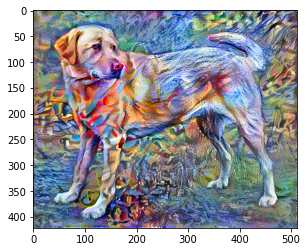

In [ ]:
imshow(tensor_to_image(image))